## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3]
redice_lr_patient = [5, 3]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
______________________________________________________________

49/49 [==============================] - 2s 31ms/step - loss: 1.2667 - accuracy: 0.5604 - val_loss: 1.4791 - val_accuracy: 0.4755
Epoch 14/25
49/49 [==============================] - 2s 31ms/step - loss: 1.2436 - accuracy: 0.5693 - val_loss: 1.4690 - val_accuracy: 0.4862
Epoch 15/25
49/49 [==============================] - 2s 32ms/step - loss: 1.2245 - accuracy: 0.5760 - val_loss: 1.4728 - val_accuracy: 0.4807
Epoch 16/25
49/49 [==============================] - 2s 32ms/step - loss: 1.2034 - accuracy: 0.5848 - val_loss: 1.4678 - val_accuracy: 0.4823
Epoch 17/25
49/49 [==============================] - 2s 32ms/step - loss: 1.1848 - accuracy: 0.5908 - val_loss: 1.4609 - val_accuracy: 0.4883
Epoch 18/25
49/49 [==============================] - 1s 30ms/step - loss: 1.1652 - accuracy: 0.5989 - val_loss: 1.4779 - val_accuracy: 0.4852
Epoch 19/25
49/49 [==============================] - 2s 33ms/step - loss: 1.1465 - accuracy: 0.6053 - val_loss: 1.4582 - val_accuracy: 0.4906
Epoch 20/25
49/49 

Epoch 1/25
49/49 [==============================] - 2s 34ms/step - loss: 2.4189 - accuracy: 0.2215 - val_loss: 2.1827 - val_accuracy: 0.1792
Epoch 2/25
49/49 [==============================] - 2s 32ms/step - loss: 1.8911 - accuracy: 0.3438 - val_loss: 2.0457 - val_accuracy: 0.2630
Epoch 3/25
49/49 [==============================] - 1s 30ms/step - loss: 1.7503 - accuracy: 0.3861 - val_loss: 1.9185 - val_accuracy: 0.3256
Epoch 4/25
49/49 [==============================] - 1s 29ms/step - loss: 1.6716 - accuracy: 0.4128 - val_loss: 1.8082 - val_accuracy: 0.3647
Epoch 5/25
49/49 [==============================] - 2s 31ms/step - loss: 1.6169 - accuracy: 0.4322 - val_loss: 1.7202 - val_accuracy: 0.3913
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 1.5718 - accuracy: 0.4465 - val_loss: 1.6615 - val_accuracy: 0.4090
Epoch 7/25
49/49 [==============================] - 2s 31ms/step - loss: 1.5368 - accuracy: 0.4594 - val_loss: 1.6228 - val_accuracy: 0.4248
Epoch 8/25
49

Epoch 22/25
49/49 [==============================] - 2s 33ms/step - loss: 0.3966 - accuracy: 0.8859 - val_loss: 1.6028 - val_accuracy: 0.5173
Epoch 23/25
49/49 [==============================] - 2s 31ms/step - loss: 0.3670 - accuracy: 0.8988 - val_loss: 1.6149 - val_accuracy: 0.5181
Epoch 24/25
49/49 [==============================] - 2s 31ms/step - loss: 0.3507 - accuracy: 0.9052 - val_loss: 1.6433 - val_accuracy: 0.5186
Epoch 25/25
49/49 [==============================] - 1s 30ms/step - loss: 0.3330 - accuracy: 0.9113 - val_loss: 1.6446 - val_accuracy: 0.5260
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 3
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_____________________

49/49 [==============================] - 1s 29ms/step - loss: 1.5929 - accuracy: 0.4409 - val_loss: 1.7565 - val_accuracy: 0.3924
Epoch 5/25
49/49 [==============================] - 1s 30ms/step - loss: 1.5482 - accuracy: 0.4558 - val_loss: 1.6793 - val_accuracy: 0.4144
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 1.5156 - accuracy: 0.4673 - val_loss: 1.6287 - val_accuracy: 0.4228
Epoch 7/25
49/49 [==============================] - 1s 29ms/step - loss: 1.4874 - accuracy: 0.4779 - val_loss: 1.6059 - val_accuracy: 0.4309
Epoch 8/25
49/49 [==============================] - 1s 29ms/step - loss: 1.4619 - accuracy: 0.4897 - val_loss: 1.5703 - val_accuracy: 0.4451
Epoch 9/25
49/49 [==============================] - 1s 29ms/step - loss: 1.4406 - accuracy: 0.4938 - val_loss: 1.5598 - val_accuracy: 0.4501
Epoch 10/25
49/49 [==============================] - 1s 29ms/step - loss: 1.4219 - accuracy: 0.5026 - val_loss: 1.5496 - val_accuracy: 0.4540
Epoch 11/25
49/49 [====

Epoch 1/25
49/49 [==============================] - 2s 39ms/step - loss: 1.8561 - accuracy: 0.3622 - val_loss: 2.5203 - val_accuracy: 0.1739
Epoch 2/25
49/49 [==============================] - 2s 35ms/step - loss: 1.5527 - accuracy: 0.4523 - val_loss: 2.0821 - val_accuracy: 0.2802
Epoch 3/25
49/49 [==============================] - 2s 36ms/step - loss: 1.4442 - accuracy: 0.4911 - val_loss: 2.0332 - val_accuracy: 0.3012
Epoch 4/25
49/49 [==============================] - 2s 36ms/step - loss: 1.3622 - accuracy: 0.5186 - val_loss: 1.9995 - val_accuracy: 0.3349
Epoch 5/25
49/49 [==============================] - 2s 37ms/step - loss: 1.2918 - accuracy: 0.5450 - val_loss: 1.9756 - val_accuracy: 0.3502
Epoch 6/25
49/49 [==============================] - 2s 36ms/step - loss: 1.2370 - accuracy: 0.5623 - val_loss: 2.1147 - val_accuracy: 0.3141
Epoch 7/25
49/49 [==============================] - 2s 37ms/step - loss: 1.1791 - accuracy: 0.5839 - val_loss: 1.6869 - val_accuracy: 0.4123
Epoch 8/25
49

Epoch 19/25
49/49 [==============================] - 2s 38ms/step - loss: 0.8191 - accuracy: 0.7341 - val_loss: 1.4159 - val_accuracy: 0.5154
Epoch 20/25
49/49 [==============================] - 2s 39ms/step - loss: 0.8066 - accuracy: 0.7389 - val_loss: 1.4162 - val_accuracy: 0.5212
Epoch 21/25
49/49 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.7419
Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
49/49 [==============================] - 2s 38ms/step - loss: 0.7967 - accuracy: 0.7419 - val_loss: 1.4451 - val_accuracy: 0.5102
Epoch 22/25
49/49 [==============================] - 2s 39ms/step - loss: 0.7730 - accuracy: 0.7524 - val_loss: 1.3848 - val_accuracy: 0.5282
Epoch 23/25
49/49 [==============================] - 2s 39ms/step - loss: 0.7646 - accuracy: 0.7567 - val_loss: 1.3917 - val_accuracy: 0.5234
Epoch 24/25
49/49 [==============================] - 2s 39ms/step - loss: 0.7595 - accuracy: 0.7596 - val_loss: 1.4008 - val_ac

49/49 [==============================] - 2s 39ms/step - loss: 1.9518 - accuracy: 0.3278 - val_loss: 2.0399 - val_accuracy: 0.2635
Epoch 4/25
49/49 [==============================] - 2s 39ms/step - loss: 1.8612 - accuracy: 0.3549 - val_loss: 1.9440 - val_accuracy: 0.2996
Epoch 5/25
49/49 [==============================] - 2s 40ms/step - loss: 1.7932 - accuracy: 0.3755 - val_loss: 1.8471 - val_accuracy: 0.3421
Epoch 6/25
49/49 [==============================] - 2s 39ms/step - loss: 1.7404 - accuracy: 0.3938 - val_loss: 1.7843 - val_accuracy: 0.3641
Epoch 7/25
49/49 [==============================] - 2s 38ms/step - loss: 1.6982 - accuracy: 0.4080 - val_loss: 1.7345 - val_accuracy: 0.3824
Epoch 8/25
49/49 [==============================] - 2s 39ms/step - loss: 1.6617 - accuracy: 0.4192 - val_loss: 1.6960 - val_accuracy: 0.3967
Epoch 9/25
49/49 [==============================] - 2s 40ms/step - loss: 1.6295 - accuracy: 0.4327 - val_loss: 1.6772 - val_accuracy: 0.4033
Epoch 10/25
49/49 [=====

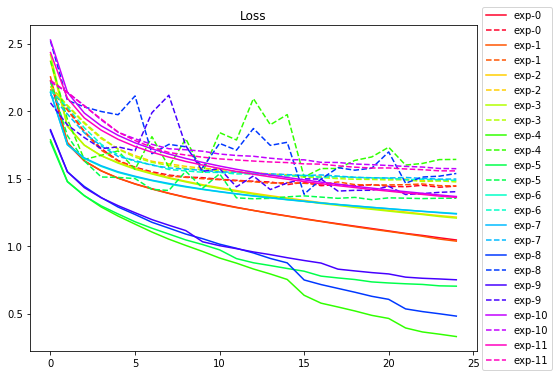

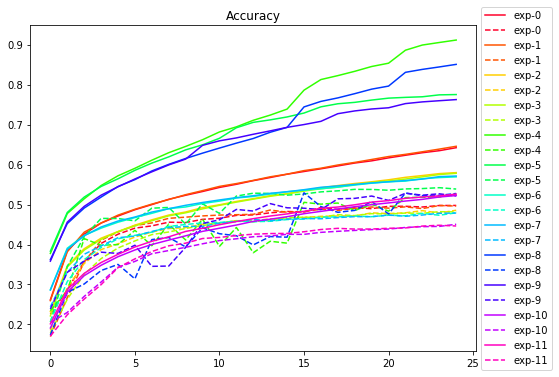

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()